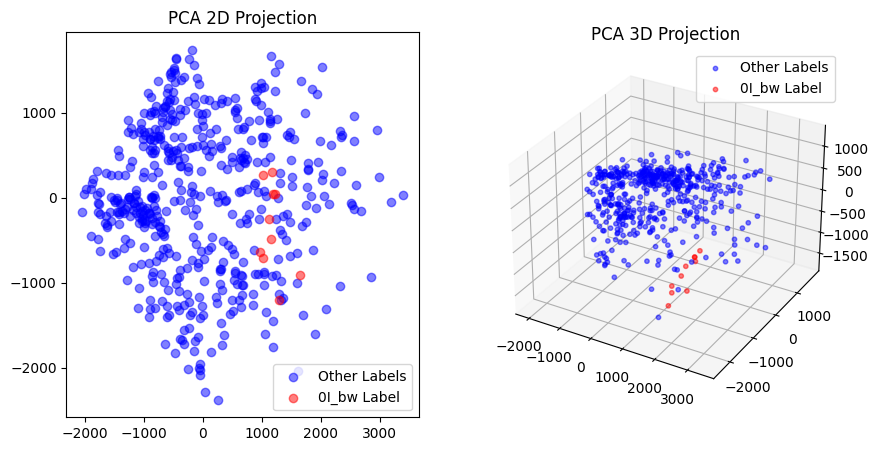

In [8]:
import os
import random
import numpy as np
import matplotlib.pyplot as plt

# 随机生成的 25 个数字
random_numbers = [30, 26, 28, 42, 17, 6, 66, 59, 25, 12, 19, 36, 64, 53, 5, 32, 67, 29, 2, 61, 35, 48, 43, 37, 22]

# 数据文件夹的路径
data_dir = "PIE"  # 请替换成包含所有子文件夹的实际路径

bw_data_dir = "0I_bw"  # 您自己的数据文件夹

# 用于存储所选的文件夹
selected_folders = []

# 遍历数据文件夹，选择与随机数字相对应的文件夹
for folder_name in os.listdir(data_dir):
    if int(folder_name) in random_numbers:
        selected_folders.append(folder_name)

# 加载数据
data = []
labels = []

# 从每个文件夹中随机选择 20 张图像
num_images_per_folder = 20

for folder_name in selected_folders:
    folder_path = os.path.join(data_dir, folder_name)
    label = int(folder_name)

    image_files = os.listdir(folder_path)
    random.shuffle(image_files)

    for image_filename in image_files[:num_images_per_folder]:
        image_path = os.path.join(folder_path, image_filename)
        data.append(image_path)
        labels.append(label)

# 从0I_bw文件夹中加载数据
bw_data = []
bw_labels = []

bw_image_files = os.listdir(bw_data_dir)
random.shuffle(bw_image_files)

for image_filename in bw_image_files[:]:
    image_path = os.path.join(bw_data_dir, image_filename)
    bw_data.append(image_path)
    bw_labels.append("0I_bw")

# 合并数据和标签
data += bw_data
labels += bw_labels

# 向量化图像数据
images = [plt.imread(image_path) for image_path in data]
X = np.array(images).reshape(len(images), -1)

# PCA函数
def My_PCA(X, n_components):
    # 计算协方差矩阵
    mean = np.mean(X, axis=0)
    X = X - mean
    covariance_matrix = np.cov(X.T)

    # 获取特征值，和特征向量
    eigenvalues, eigenvectors = np.linalg.eig(covariance_matrix)
    eigenvectors = np.real(eigenvectors)
    
    # 对特征值进行排序
    sorted_indices = np.argsort(eigenvalues)[::-1]
    eigenvalues = eigenvalues[sorted_indices]
    eigenvectors = eigenvectors[:, sorted_indices]
    
    top_n_eigenvectors = eigenvectors[:, :n_components]
    
    X_pca = X @ top_n_eigenvectors
    return X_pca, top_n_eigenvectors

# 应用PCA降维
X_2d, _ = My_PCA(X, n_components=2)

X_3d, top_3_eigenvectors = My_PCA(X, n_components=3)

# 分离"0I_bw"标签的数据
my_data_indices = [i for i, label in enumerate(labels) if label == "0I_bw"]
other_data_indices = [i for i, label in enumerate(labels) if label != "0I_bw"]

# 可视化投影后的数据，并突出显示"0I_bw"标签的点
plt.figure(figsize=(10, 5))
plt.subplot(1, 2, 1)
plt.scatter(X_2d[other_data_indices, 0], X_2d[other_data_indices, 1], c='blue', label='Other Labels', alpha=0.5)
plt.scatter(X_2d[my_data_indices, 0], X_2d[my_data_indices, 1], c='red', label='0I_bw Label', alpha=0.5)
plt.title('PCA 2D Projection')
plt.legend()

ax = plt.subplot(1, 2, 2, projection='3d')

scatter_other = ax.scatter(X_3d[other_data_indices, 0], X_3d[other_data_indices, 1], X_3d[other_data_indices, 2], c='blue', label='Other Labels', s=10, alpha=0.5)
scatter_bw = ax.scatter(X_3d[my_data_indices, 0], X_3d[my_data_indices, 1], X_3d[my_data_indices, 2], c='red', label='0I_bw Label', s=10, alpha=0.5)
plt.title('PCA 3D Projection')
plt.legend(handles=[scatter_other, scatter_bw], labels=['Other Labels', '0I_bw Label'])

plt.show()

In [14]:
from sklearn.model_selection import train_test_split
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import accuracy_score

k = 1 # KNN的参数
iter = [40, 80, 200] # 维度矩阵

knn = KNeighborsClassifier(n_neighbors=k)

for i in iter:
    X_pca = My_PCA(X, n_components=i)
    X_train, X_test, y_train, y_test = train_test_split(X_pca, labels, test_size=0.3, random_state=42)
    knn.fit(X_train, y_train)
    y_pred = knn.predict(X_test)
    accuracy = accuracy_score(y_test, y_pred)
    # ‘我’ 的识别准确率
    my_data_indices = [i for i, label in enumerate(y_test) if label == "0I_bw"]
    X_bw_test = X_test[my_data_indices]
    y_bw_test = [y_test[i] for i in my_data_indices]
    # 训练KNN分类器
    knn.fit(X_train, y_train)
    # 使用KNN进行预测
    y_bw_pred = knn.predict(X_bw_test)
    # 计算错误率
    my_accuracy = accuracy_score(y_bw_test, y_bw_pred)
    print(f"accuracy: {accuracy:.3f}, Myaccuracy: {my_accuracy:.3f} in the case of dimension {i}")

accuracy: 0.425, Myaccuracy: 1.000 in the case of dimension 40
accuracy: 0.464, Myaccuracy: 1.000 in the case of dimension 80
accuracy: 0.484, Myaccuracy: 1.000 in the case of dimension 200


(32, 32, 3)


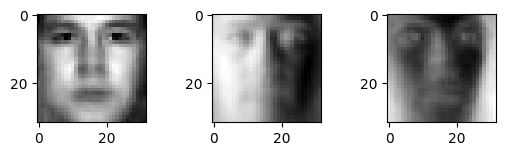

In [23]:
print(top_3_eigenvectors.shape)
for i in range(0, 3):
    plt.subplot(3,3,i+1)
    plt.imshow(top_3_eigenvectors[:, :, i].astype(float), cmap='gray')
plt.show()